# Specter embeddings

In this notebook, we perform a clustering analysis of COVID-19 publications using [SPECTRE embeddings](https://github.com/allenai/paper-embedding-public-apis).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# magics and warnings
%load_ext autoreload
%autoreload 2
import warnings; warnings.simplefilter('ignore')

import os, random, codecs, json, pickle
import pandas as pd
import numpy as np

seed = 99
random.seed(seed)
np.random.seed(seed)

import nltk, sklearn
import matplotlib.pyplot as plt
from  matplotlib.ticker import FuncFormatter
import seaborn as sns
sns.set(style="white")
sns.set_context("paper", font_scale=1.2, rc={"lines.linewidth": 2.5})

In [2]:
df_meta = pd.read_csv("data/df_meta.csv",compression="gzip")
df_joined_all = pd.read_csv("data/df_joined_all.csv", compression="gzip")

In [3]:
df_meta.abstract = df_meta['abstract'].fillna('')
df_meta.title = df_meta['title'].fillna('')

In [4]:
df_meta.head()

pub_id                                              title  \
0       0  ‘A ticking time bomb’: Scientists worry about ...   
1       1  [Ten hot issues of breast cancer under the nov...   
2       2  Another Piece of the Puzzle: Human Metapneumov...   
3       3  Viral etiology of severe pneumonia among Kenya...   
4       4  Critically Ill Patients With Influenza A(H1N1)...   

                                            abstract  publication_year  \
0  CAPE TOWN, SOUTH AFRICA—Late on Sunday evening...            2020.0   
1                                                               2020.0   
2  BACKGROUND: Each winter respiratory viruses ac...            2008.0   
3  CONTEXT: Pneumonia is the leading cause of chi...            2010.0   
4                                                               2014.0   

   publication_month                        journal volume issue pages  \
0                NaN                        Science    NaN   NaN   NaN   
1                2.0        Chinese medical journal    100     0  e002   
2               12.0  Archives of Internal Medicine    NaN   NaN   NaN   
3                5.0                           JAMA    NaN   NaN   NaN   
4                4.0                           JAMA    NaN   NaN   NaN   

                                      doi        pmid       pmcid  \
0                  0.1126/science.abb7331         NaN         NaN   
1  10.0376/cma.j.issn.0376-2491.2020.0002  32036640.0         NaN   
2            10.1001/archinte.168.22.2489  19064834.0  pmc2783624   
3                   10.1001/jama.2010.675  20501927.0  pmc2968755   
4                  10.1001/jama.2014.2116  24566924.0  pmc6689404   

    dimensions_id                   timestamp lang  
0             NaN  2020-04-25 09:08:51.611715   en  
1  pub.1124777091  2020-04-25 09:08:51.611715   en  
2             NaN  2020-04-25 09:08:51.611715   en  
3             NaN  2020-04-25 09:08:51.611715   en  
4             NaN  2020-04-25 09:08:51.611715   en

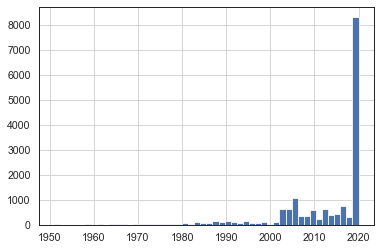

In [5]:
df_meta[(df_meta.abstract=="") & (df_meta.publication_year<2021)].publication_year.hist(bins=50)

In [6]:
ALL_PAPERS = list()
for pid,t,a in zip(df_meta[df_meta.lang=='en'].pub_id.to_list(),df_meta[df_meta.lang=='en'].title.to_list(),df_meta[df_meta.lang=='en'].abstract.to_list()):
    if len(t) and len(a):
        ALL_PAPERS.append({"paper_id":pid,"title":t,"abstract":a})
    elif len(t):
        ALL_PAPERS.append({"paper_id":pid,"title":t,"abstract":t}) # we use the title as abstract
    else:
        continue

In [7]:
df_meta.shape

(69969, 15)

In [8]:
len(ALL_PAPERS)

66762

In [9]:
paper_to_id = {n:pid["paper_id"] for n,pid in enumerate(ALL_PAPERS)}

### Query SPECTER API

In [38]:
# From https://github.com/allenai/paper-embedding-public-apis

from typing import Dict, List
import json
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry


URL = "https://model-apis.semanticscholar.org/specter/v1/invoke"
MAX_BATCH_SIZE = 16


def chunks(lst, chunk_size=MAX_BATCH_SIZE):
    """Splits a longer list to respect batch size"""
    for i in range(0, len(lst), chunk_size):
        yield lst[i : i + chunk_size]


def embed(papers):
    embeddings_by_paper_id: Dict[str, List[float]] = {}
        
    session = requests.Session()
    retry = Retry(connect=5, backoff_factor=0.5)
    adapter = HTTPAdapter(max_retries=retry)
    session.mount('http://', adapter)
    session.mount('https://', adapter)
    
    for n,chunk in enumerate(chunks(papers)):
        # Allow Python requests to convert the data above to JSON
        response = session.post(URL, json=chunk)

        if response.status_code != 200:
            print(chunk)
            #raise RuntimeError("Sorry, something went wrong, please try later!")
            continue

        for paper in response.json()["preds"]:
            embeddings_by_paper_id[paper["paper_id"]] = paper["embedding"]
        #print(n)
        if n%1000 == 0:
            print("Done chunk",n)

    return embeddings_by_paper_id

In [39]:
all_embeddings = embed(ALL_PAPERS)

Done chunk 0
Done chunk 1000
Done chunk 2000
Done chunk 3000
Done chunk 4000


In [40]:
pickle.dump(all_embeddings,open("data/specter_embeddings.pk","wb"))

In [20]:
all_embeddings = pickle.load(open("data/specter_embeddings.pk","rb"))

In [21]:
len(all_embeddings)

66762

In [22]:
len(ALL_PAPERS)

66762

In [23]:
X = np.matrix([v for v in all_embeddings.values()])

In [24]:
X.shape

(66762, 768)

### t-SNE

In [45]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=0, perplexity=50, early_exaggeration=15, n_iter=2000, random_state=seed, metric='cosine', n_jobs=6)
X_embedded = tsne.fit_transform(X)

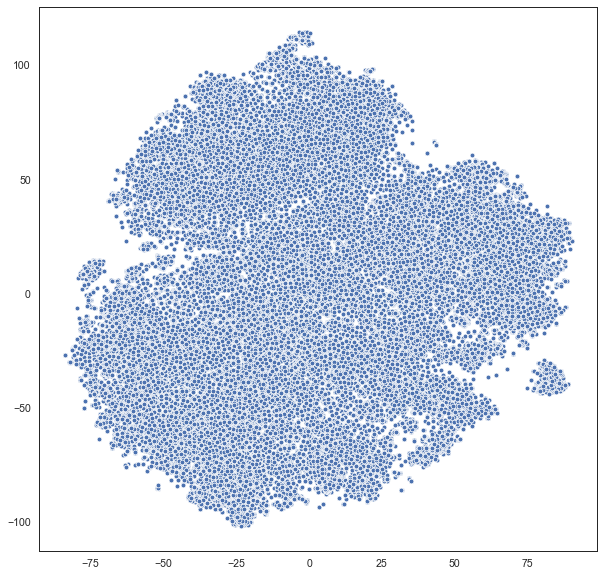

In [46]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], palette=sns.color_palette("bright", 1))
#plt.title('t-SNE with no Labels')
plt.savefig("figures/nb3_tsne_vanilla.pdf")
plt.show()

In [25]:
# create a vector with in_wikipedia or not for all papers with embeddings

y = list()
             
inwiki = df_joined_all[df_joined_all.in_wikipedia==1].pub_id.to_list()
                 
for n,k in enumerate(all_embeddings.keys()):
    if k in inwiki:
        y.append(1)
    else:
        y.append(0)

In [26]:
y = np.array(y)

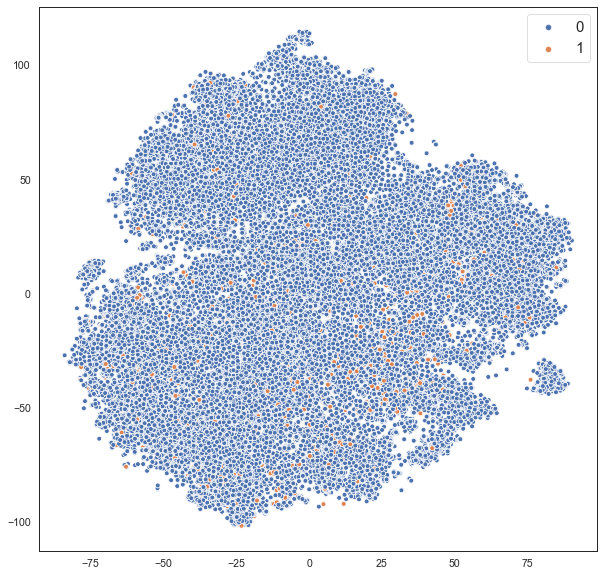

In [49]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y, legend='full')
#plt.title('t-SNE with Kmeans Labels')
plt.legend(fontsize=15)
plt.savefig("figures/nb3_tsne_in_wiki.pdf")
plt.show()

### K-means

In [27]:
# number of clusters
# see below for Elbow and Silouhette analyses 
k = 20

In [28]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=k, random_state=seed, max_iter=1000, n_jobs=6)
y_pred = kmeans.fit_predict(X)

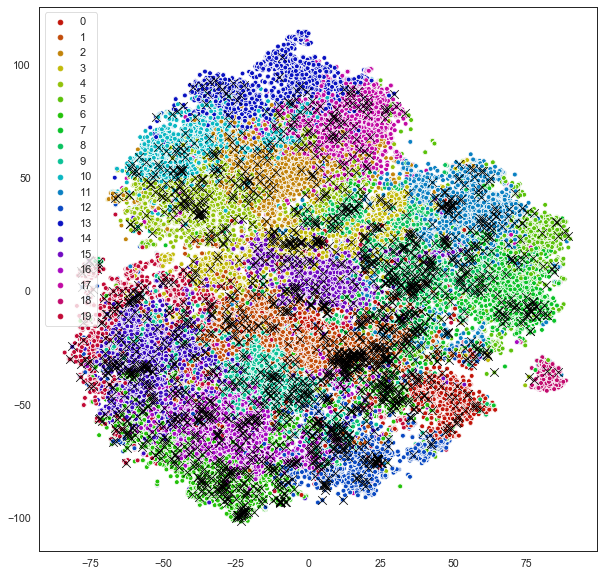

In [58]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=sns.hls_palette(20, l=.4, s=.9))
sns.scatterplot(X_embedded[y==1][:,0], X_embedded[y==1][:,1], legend=False, marker="x", color="black", s=75)
#plt.title('t-SNE with Kmeans Labels')
plt.legend(fontsize=11)
plt.savefig("figures/nb3_tsne_kmeans_in_wiki.pdf")
plt.show()

In [53]:
# list closest 10 papers to centroids
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, X, metric='cosine')
closest

array([19264, 46262, 59234, 47884,  6124, 54678, 23467, 36120, 18509,
       29721, 54453, 51719, 28364,  9192, 50717, 45782, 50727, 27879,
       52385, 45691])

In [54]:
for n,c in enumerate(closest):
    print("Cluster",n,df_meta.iloc[paper_to_id[c]].title)

Cluster 0 Evaluation of a single-tube fluorogenic RT-PCR assay for detection of bovine respiratory syncytial virus in clinical samples
Cluster 1 S1 gene sequence analysis of a nephropathogenic strain of avian infectious bronchitis virus in Egypt
Cluster 2 [Cardiac manifestations of patients with COVID-19 pneumonia and related treatment recommendations].
Cluster 3 Necrotizing pneumonia: an emerging problem in children?
Cluster 4 Clinical trials for the treatment of Coronavirus disease 2019 (COVID-19): A rapid response to urgent need
Cluster 5 Covid-19 Pandemic; Recession, Virtual Revolution Leading to De-globalization?
Cluster 6 Host cell proteins interacting with the 3′ end of TGEV coronavirus genome influence virus replication
Cluster 7 Simulation-based Estimation of the Spread of COVID-19 in Iran
Cluster 8 The epidemiological and clinical features of COVID-19 and lessons from this global infectious public health event
Cluster 9 Generation of therapeutic antisera for emerging viral in

In [55]:
# plot cluster % of papers cited from Wikipedia, against cluster size

In [56]:
cluster_coverage = list()
cluster_size = list()
cluster_number = list()

# also calculate paper centralities wrt. cluster centroid
# for every paper, this is 1 - the (cosine) distance wrt. its centroid
# we need both similarity and args to index results

for c in range(k):
    cl_size = len(y_pred[y_pred==c])
    coverage = len(y_pred[(y==1)&(y_pred==c)])/cl_size
    #print("Cluster",c,coverage)
    cluster_coverage.append(coverage)
    cluster_size.append(cl_size)
    cluster_number.append(c)

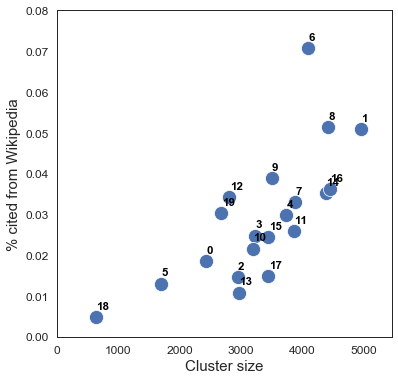

In [63]:
plt.figure(figsize=(6,6))
pl = sns.scatterplot(x=cluster_size,y=cluster_coverage,s=200)
# add annotations one by one with a loop
for dot in range(k):
     pl.text(cluster_size[dot]+7, cluster_coverage[dot]+0.002, s=cluster_number[dot], horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.ylim((0,0.08))
plt.xlim((0,max(cluster_size)+500))
plt.tick_params(labelsize=12)
plt.ylabel("% cited from Wikipedia",fontsize=15)
plt.xlabel("Cluster size",fontsize=15)
plt.savefig("figures/nb3_cluster_size_vs_wiki_coverage.pdf")

In [65]:
# export cluster identity and semantic centrality of each paper

from sklearn.metrics.pairwise import cosine_similarity

cluster_semantic_similarities = list()

for k,centroid in enumerate(kmeans.cluster_centers_):
    cos_sim = cosine_similarity(centroid.reshape((1,X.shape[1])), X)
    cluster_semantic_similarities.append(cos_sim)

In [66]:
S = np.stack([s.ravel() for s in cluster_semantic_similarities],axis=1)

In [67]:
S.shape

(66762, 20)

In [68]:
# find the similarity with cluster centroid
T = S[np.arange(len(S)),y_pred]

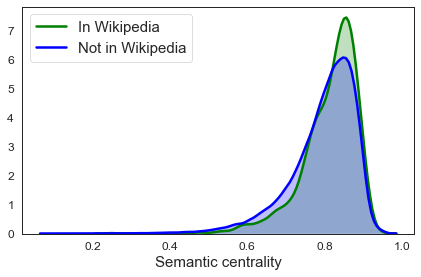

In [69]:
# distribution of semantic centrality for papers cited from Wikipedia or not
#plt.figure(figsize=(10,8))
sns.distplot(T[y==1], color="green", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="In Wikipedia")
sns.distplot(T[y==0], color="blue", kde=True, norm_hist=True, kde_kws={"shade": True}, hist=False, label="Not in Wikipedia")
plt.legend(fontsize=15)
plt.xlabel("Semantic centrality",fontsize=15)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig("figures/nb3_semantic_centrality.pdf")

In [70]:
# create data frame and export

In [71]:
pub_ids = list()
cluster_ids = list()
semantic_centralities = list()
cluster_sizes = list()

for n in range(len(y)):
    pub_ids.append(paper_to_id[n])
    cluster_ids.append(y_pred[n])
    semantic_centralities.append(T[n])
    cluster_sizes.append(len(y_pred[y_pred==y_pred[n]]))

In [72]:
df_specter = pd.DataFrame.from_dict({"pub_id":pub_ids,"spectre_cluster_id":cluster_ids,"spectre_cluster_size":cluster_sizes,"spectre_semantic_centrality":semantic_centralities})
df_specter.to_csv("data/df_spectre.csv", index=False, compression="gzip")

### Topic models

In [10]:
# you can select here if to use an LDA or a CTM topic model
df_topic_intensity = pd.read_csv("data/df_topic_intensity.csv", compression="gzip")
#df_topic_intensity = pd.read_csv("data/df_topic_intensity_ctm.csv", compression="gzip")
df_specter = pd.read_csv("data/df_spectre.csv", compression="gzip")

In [11]:
df_topic_intensity.head()

tm_coronaviruses  tm_transmission    tm_phe  tm_molecular_biology  \
0          0.166054         0.000000  0.782990              0.000000   
1          0.381396         0.104781  0.114435              0.325978   
2          0.427406         0.000000  0.000000              0.000000   
3          0.639613         0.011437  0.000000              0.000000   
4          0.191039         0.000000  0.000000              0.145550   

   tm_respiratory_diseases  tm_immunology  tm_clinical_medicine  pub_id  
0                 0.000000       0.043276              0.000000       0  
1                 0.000000       0.000000              0.000000       1  
2                 0.304966       0.000000              0.258405       2  
3                 0.202549       0.017787              0.126117       3  
4                 0.285993       0.000000              0.326059       4

In [12]:
df_topic_intensity.columns

Index(['tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine',
       'pub_id'],
      dtype='object')

In [13]:
topic_labels = ['tm_coronaviruses', 'tm_transmission', 'tm_phe', 'tm_molecular_biology',
       'tm_respiratory_diseases', 'tm_immunology', 'tm_clinical_medicine']

In [14]:
tm_names = {"Coronaviruses": "tm_coronaviruses",
    "Public health and epidemics": "tm_phe",
    "Transmission": "tm_transmission",
    "Molecular biology": "tm_molecular_biology",
    "Respiratory diseases": "tm_respiratory_diseases",
    "Immunology": "tm_immunology",
    "Clinical medicine": "tm_clinical_medicine"}
topic_labels = [x for x in tm_names.keys()]
reverse_tm_names = {x:y for y,x in tm_names.items()}
df_topic_intensity.rename(columns=reverse_tm_names,inplace=True)

In [15]:
df_embeddings = df_specter[["pub_id","spectre_cluster_id"]]

In [16]:
df_embeddings.shape

(66762, 2)

In [17]:
df_topic_intensity.shape

(66915, 8)

In [18]:
df_embeddings = df_embeddings.merge(df_topic_intensity, how="inner", left_on="pub_id", right_on="pub_id")
df_embeddings = df_embeddings.merge(df_meta[["pub_id","publication_year"]], how="inner", left_on="pub_id", right_on="pub_id")

In [19]:
df_embeddings.shape

(66762, 10)

In [176]:
which_cluster = 5

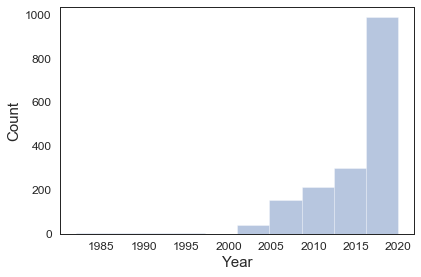

In [177]:
#plt.figure(figsize=(9,6))
sns.distplot(df_embeddings[df_embeddings.spectre_cluster_id == which_cluster].publication_year, bins=10, kde=False)
plt.xlabel("Year",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.tick_params(labelsize=12)
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))
plt.tight_layout()
#plt.savefig("figures/nb3_cluster_%d_yeardistr.pdf"%(which_cluster))

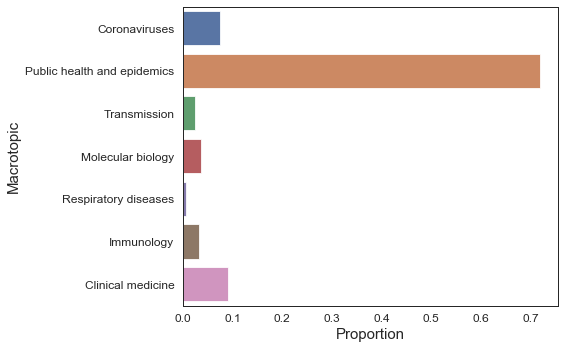

In [178]:
plt.figure(figsize=(8,5))
df_sub = df_embeddings[df_embeddings.spectre_cluster_id == which_cluster][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
b.tick_params(labelsize=12)
plt.tight_layout()
#plt.savefig("figures/nb3_cluster_%d_to_topicmodel.pdf"%(which_cluster))

In [179]:
# examples of central papers in a cluster

df_specter[df_specter.spectre_cluster_id==which_cluster].merge(df_meta[["title","publication_year","journal","pub_id"]], how="left", right_on="pub_id", left_on="pub_id").sort_values("spectre_semantic_centrality",ascending=False).head(10)

pub_id  spectre_cluster_id  spectre_cluster_size  \
1535   57355                   5                  1699   
1403   56113                   5                  1699   
1340   55847                   5                  1699   
35      1967                   5                  1699   
1071   34909                   5                  1699   
1366   55967                   5                  1699   
1446   56295                   5                  1699   
1119   40249                   5                  1699   
1257   53835                   5                  1699   
1332   55830                   5                  1699   

      spectre_semantic_centrality  \
1535                     0.853419   
1403                     0.850380   
1340                     0.840609   
35                       0.838232   
1071                     0.837814   
1366                     0.832133   
1446                     0.832013   
1119                     0.828618   
1257                     0.825718   
1332                     0.824810   

                                                  title  publication_year  \
1535  Covid-19 Pandemic; Recession, Virtual Revoluti...            2020.0   
1403  COVID-19 Pandemic and Economic Crisis: The Nig...            2020.0   
1340  Responding to COVID-19 Through Socialist(ic) M...            2020.0   
35    Managing threats in the global era: The impact...            2006.0   
1071  The Changing Face of Crises and Aid in the Asi...            2014.0   
1366  Spillover of COVID-19: Impact on the Global Ec...            2020.0   
1446  The Pandemic Case for Supra-National Governanc...            2020.0   
1119  Capitalism is making us sick: poverty, illness...            2010.0   
1257  RISK UNIVERSITY: UNCERTAINTY OF THE LATE MODER...            2020.0   
1332  The Legality of the European Central Bank's Pa...            2020.0   

                                                journal  
1535                Journal of Intercultural Management  
1403                            SSRN Electronic Journal  
1340                            SSRN Electronic Journal  
35                                                  NaN  
1071  Biosecurity and Bioterrorism: Biodefense Strat...  
1366                            SSRN Electronic Journal  
1446                            SSRN Electronic Journal  
1119                                                NaN  
1257                                   Society Register  
1332                            SSRN Electronic Journal

#### Topics cited from Wikipedia or not

In [24]:
df_embeddings_tm = df_embeddings.merge(df_joined_all[["pub_id","in_wikipedia","title"]], how="left", left_on="pub_id", right_on="pub_id")
df_embeddings_tm.in_wikipedia = df_embeddings_tm['in_wikipedia'].fillna(False)

In [25]:
df_embeddings_tm.shape

(66762, 12)

#### Overall

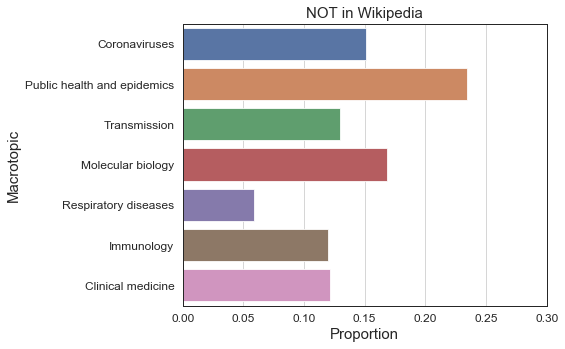

In [69]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
b.set_title("NOT in Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW.pdf")

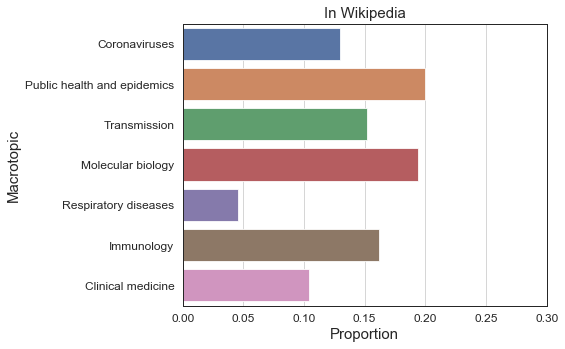

In [70]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W.pdf")

In [26]:
df_melted = df_embeddings_tm[topic_labels+["pub_id"]].melt(id_vars=["pub_id"], var_name='topic_intensity')
df_melted = df_melted.merge(df_embeddings_tm[["pub_id","in_wikipedia","publication_year"]], how="left", left_on="pub_id", right_on="pub_id")

In [27]:
df_embeddings_tm.shape

(66762, 12)

In [28]:
df_melted.shape

(467334, 5)

In [29]:
df_embeddings_tm.shape[0] * len(topic_labels)

467334

In [30]:
df_melted.head()

pub_id topic_intensity     value  in_wikipedia  publication_year
0       0   Coronaviruses  0.166054         False            2020.0
1       1   Coronaviruses  0.381396         False            2020.0
2       2   Coronaviruses  0.427406          True            2008.0
3       3   Coronaviruses  0.639613         False            2010.0
4       4   Coronaviruses  0.191039         False            2014.0

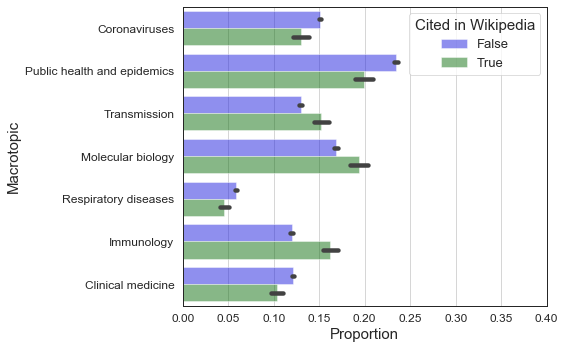

In [77]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="topic_intensity", x="value", hue="in_wikipedia", data=df_melted, estimator=np.mean, ci=95, palette=["blue","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.legend(title="Cited in Wikipedia", fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_hue_ALL.pdf")

In [49]:
# https://en.wikipedia.org/wiki/Effect_size#Cohen's_d

def cohensd(d1, d2):
    # sample size
    n1, n2 = len(d1), len(d2)
    # variance
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # s
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # u
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

In [50]:
from scipy import stats
cohens_d_all = list()
kruskal_all = list()

for mt in topic_labels:
    cod = np.abs(cohensd(df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][mt].values,df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][mt].values))
    cohens_d_all.append(cod)
    kr = stats.kruskal(df_embeddings_tm[df_embeddings_tm.in_wikipedia == False][mt].values,df_embeddings_tm[df_embeddings_tm.in_wikipedia == True][mt].values)
    kruskal_all.append(kr)
    print(mt,str(cod),kr.pvalue)

Coronaviruses 0.09791457476806262 2.439887162570569e-07
Public health and epidemics 0.11754801492429483 0.10198627930206866
Transmission 0.11531891691920138 1.3377509715860663e-12
Molecular biology 0.1063121568724663 8.904710417456927e-07
Respiratory diseases 0.09728602360658711 0.0010950561179638584
Immunology 0.23494455467733388 3.1873968568224365e-31
Clinical medicine 0.09828719446949512 2.1882059434278778e-07


#### 2020

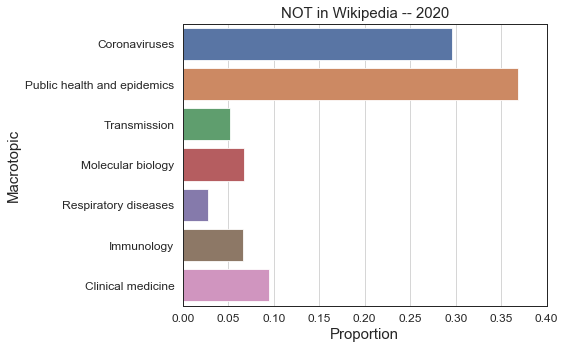

In [78]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year==2020) & (df_embeddings_tm.in_wikipedia == False)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia -- 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW_2020.pdf")

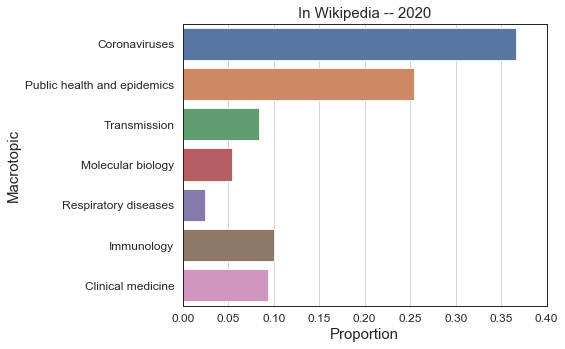

In [79]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year==2020) & (df_embeddings_tm.in_wikipedia == True)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia -- 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W_2020.pdf")

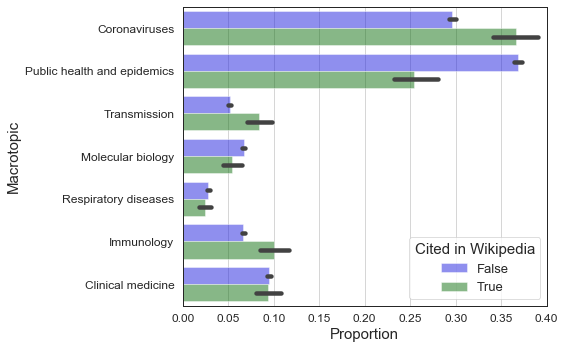

In [44]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="topic_intensity", x="value", hue="in_wikipedia", data=df_melted[df_melted.publication_year==2020], estimator=np.mean, ci=95, palette=["blue","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.legend(title="Cited in Wikipedia", fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_hue_2020.pdf")

In [48]:
cohens_d_2020 = list()
kruskal_2020 = list()

for mt in topic_labels:
    cod = np.abs(cohensd(df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values))
    cohens_d_2020.append(cod)
    kr = stats.kruskal(df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year==2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
    kruskal_2020.append(kr)
    print(mt,str(cod),kr.pvalue)

Coronaviruses 0.2735416366022424 1.2561769114106436e-09
Public health and epidemics 0.36607207700880007 2.3126353795787616e-11
Transmission 0.29099907632449745 4.6421895894340453e-07
Molecular biology 0.09414232184539617 0.2826260445722074
Respiratory diseases 0.04359136154937137 0.8399692725010868
Immunology 0.24111680020522824 0.0006194196330189535
Clinical medicine 0.008342483715874207 0.5133275909142607


#### Before 2020

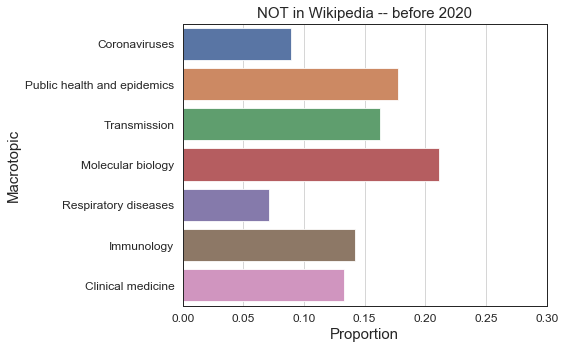

In [82]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year<2020) & (df_embeddings_tm.in_wikipedia == False)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("NOT in Wikipedia -- before 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_notW_before_2020.pdf")

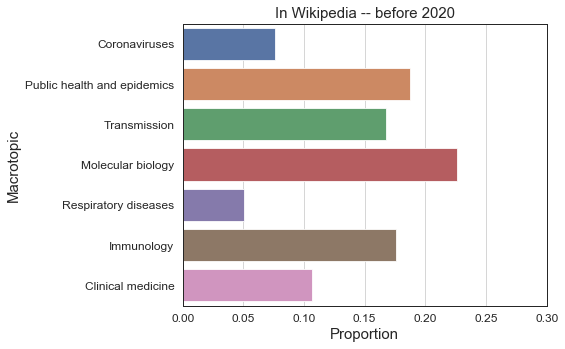

In [83]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
df_sub = df_embeddings_tm[(df_embeddings_tm.publication_year<2020) & (df_embeddings_tm.in_wikipedia == True)][[mt for mt in topic_labels]].mean()
b = sns.barplot(y=df_sub.index,x=df_sub.values)
#b.axes.set_title("Title",fontsize=50)
b.set_title("In Wikipedia -- before 2020",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.3))
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_W_before_2020.pdf")

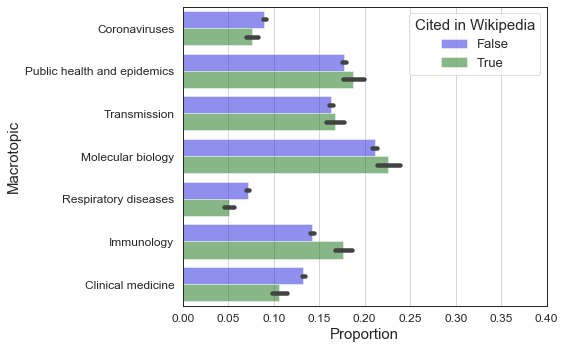

In [46]:
plt.figure(figsize=(8,5))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="topic_intensity", x="value", hue="in_wikipedia", data=df_melted[df_melted.publication_year<2020], estimator=np.mean, ci=95, palette=["blue","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Proportion",fontsize=15)
b.set_ylabel("Macrotopic",fontsize=15)
#b.set_title("Clustering")
b.tick_params(labelsize=12)
plt.xlim((0,0.4))
plt.legend(title="Cited in Wikipedia", fontsize=13, title_fontsize=15)
plt.tight_layout()
plt.savefig("figures/nb3_topic_model_hue_before_2020.pdf")

In [47]:
cohens_d_before = list()
kruskal_before = list()

for mt in topic_labels:
    cod = np.abs(cohensd(df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values))
    cohens_d_before.append(cod)
    kr = stats.kruskal(df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == False)][mt].values,df_embeddings_tm[(df_embeddings.publication_year<2020)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
    kruskal_before.append(kr)
    mean_beforebefore.append()
    print(mt,str(cod),kr.pvalue)

Coronaviruses 0.08406278664905886 0.005717579505202176
Public health and epidemics 0.03761956309922108 2.1300764150144376e-07
Transmission 0.022398375500461257 0.06942668386782806
Molecular biology 0.056100148105217504 0.0114283563064668
Respiratory diseases 0.14373479048759205 8.078194326652135e-08
Immunology 0.17826683004829125 2.2361009511466303e-16
Clinical medicine 0.1395255653986912 2.9857015028853753e-10


In [127]:
def p_to_ast(p):
    if p < 0.01:
        return "***"
    elif p <= 0.05:
        return "**"
    elif p <= 0.1:
        return "*"
    return " "
    
df_tests = pd.DataFrame.from_dict({"macrotopic":topic_labels,"cohensd_all":cohens_d_all,"cohensd_2020":cohens_d_2020,"cohensd_before":cohens_d_before,
                                  "kwh_p_all":[k.pvalue for k in kruskal_all],"kwh_p_2020":[k.pvalue for k in kruskal_2020],"kwh_p_before":[k.pvalue for k in kruskal_before],
                                   "kwh_ps_all":[p_to_ast(k.pvalue) for k in kruskal_all],"kwh_ps_2020":[p_to_ast(k.pvalue) for k in kruskal_2020],"kwh_ps_before":[p_to_ast(k.pvalue) for k in kruskal_before],
                                  "kwh_stat_all":[k.statistic for k in kruskal_all],"kwh_stat_2020":[k.statistic for k in kruskal_2020],"kwh_stat_before":[k.statistic for k in kruskal_before]})
#df_tests["id"] = df_tests.index

In [128]:
df_tests

macrotopic  cohensd_all  cohensd_2020  cohensd_before  \
0                Coronaviruses     0.097915      0.273542        0.084063   
1  Public health and epidemics     0.117548      0.366072        0.037620   
2                 Transmission     0.115319      0.290999        0.022398   
3            Molecular biology     0.106312      0.094142        0.056100   
4         Respiratory diseases     0.097286      0.043591        0.143735   
5                   Immunology     0.234945      0.241117        0.178267   
6            Clinical medicine     0.098287      0.008342        0.139526   

      kwh_p_all    kwh_p_2020  kwh_p_before kwh_ps_all kwh_ps_2020  \
0  2.439887e-07  1.256177e-09  5.717580e-03        ***         ***   
1  1.019863e-01  2.312635e-11  2.130076e-07                    ***   
2  1.337751e-12  4.642190e-07  6.942668e-02        ***         ***   
3  8.904710e-07  2.826260e-01  1.142836e-02        ***               
4  1.095056e-03  8.399693e-01  8.078194e-08        ***               
5  3.187397e-31  6.194196e-04  2.236101e-16        ***         ***   
6  2.188206e-07  5.133276e-01  2.985702e-10        ***               

  kwh_ps_before  kwh_stat_all  kwh_stat_2020  kwh_stat_before  
0           ***     26.648907      36.880161         7.637226  
1           ***      2.674204      44.686354        26.911320  
2             *     50.273036      25.407048         3.296523  
3            **     24.151493       1.154419         6.397463  
4           ***     10.659523       0.040777        28.787231  
5           ***    135.069949      11.716692        67.382632  
6           ***     26.859284       0.427278        39.683943

In [129]:
df_melted_tests = df_tests.melt(id_vars=["macrotopic"])

In [130]:
df_melted_tests["period"] = df_melted_tests["variable"].apply(lambda x:x.split("_")[-1])
df_melted_tests["variable"] = df_melted_tests["variable"].apply(lambda x:"_".join(x.split("_")[:-1]))

In [131]:
df_melted_tests

macrotopic  variable      value  period
0                 Coronaviruses   cohensd  0.0979146     all
1   Public health and epidemics   cohensd   0.117548     all
2                  Transmission   cohensd   0.115319     all
3             Molecular biology   cohensd   0.106312     all
4          Respiratory diseases   cohensd   0.097286     all
..                          ...       ...        ...     ...
79                 Transmission  kwh_stat    3.29652  before
80            Molecular biology  kwh_stat    6.39746  before
81         Respiratory diseases  kwh_stat    28.7872  before
82                   Immunology  kwh_stat    67.3826  before
83            Clinical medicine  kwh_stat    39.6839  before

[84 rows x 4 columns]

In [161]:
# effect and test tables 

# EXAMPLE row for paper:
# Coronaviruses & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{52} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} & \multicolumn{1}{r}{0} \\

table_item = "\multicolumn{1}{r}{%s}"
for period in ["before","2020","all"]:
    print("==== %s ===="%period)
    condition = df_embeddings.publication_year<3000
    if period == "before":
        condition = df_embeddings.publication_year<2020
    elif period == "2020":
        condition = df_embeddings.publication_year==2020
    for mt in topic_labels:
        mean_in = np.mean(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
        sd_in = np.std(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == True)][mt].values)
        mean_not = np.mean(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == False)][mt].values)
        sd_not = np.std(df_embeddings_tm[(condition)&(df_embeddings_tm.in_wikipedia == False)][mt].values)
        kwh = df_melted_tests[(df_melted_tests.macrotopic==mt)&(df_melted_tests.period==period)&(df_melted_tests.variable=="kwh_stat")].value
        p = df_melted_tests[(df_melted_tests.macrotopic==mt)&(df_melted_tests.period==period)&(df_melted_tests.variable=="kwh_p")].value
        cd = df_melted_tests[(df_melted_tests.macrotopic==mt)&(df_melted_tests.period==period)&(df_melted_tests.variable=="cohensd")].value
        row_values = [mean_in,sd_in,mean_not,sd_not,kwh,p,cd]
        print(mt,"&"," & ".join([table_item%format(round(float(v),3)) for v in row_values]),"\\\\")
    print("\n")

==== before ====
Coronaviruses & \multicolumn{1}{r}{0.076} & \multicolumn{1}{r}{0.143} & \multicolumn{1}{r}{0.09} & \multicolumn{1}{r}{0.163} & \multicolumn{1}{r}{7.637} & \multicolumn{1}{r}{0.006} & \multicolumn{1}{r}{0.084} \\
Public health and epidemics & \multicolumn{1}{r}{0.187} & \multicolumn{1}{r}{0.256} & \multicolumn{1}{r}{0.177} & \multicolumn{1}{r}{0.265} & \multicolumn{1}{r}{26.911} & \multicolumn{1}{r}{0.0} & \multicolumn{1}{r}{0.038} \\
Transmission & \multicolumn{1}{r}{0.168} & \multicolumn{1}{r}{0.206} & \multicolumn{1}{r}{0.163} & \multicolumn{1}{r}{0.21} & \multicolumn{1}{r}{3.297} & \multicolumn{1}{r}{0.069} & \multicolumn{1}{r}{0.022} \\
Molecular biology & \multicolumn{1}{r}{0.226} & \multicolumn{1}{r}{0.268} & \multicolumn{1}{r}{0.211} & \multicolumn{1}{r}{0.265} & \multicolumn{1}{r}{6.397} & \multicolumn{1}{r}{0.011} & \multicolumn{1}{r}{0.056} \\
Respiratory diseases & \multicolumn{1}{r}{0.051} & \multicolumn{1}{r}{0.114} & \multicolumn{1}{r}{0.071} & \multicolu

In [152]:
"\multicolumn{1}{r}{%s}"%format(round(2.44444,2))

'\\multicolumn{1}{r}{2.44}'

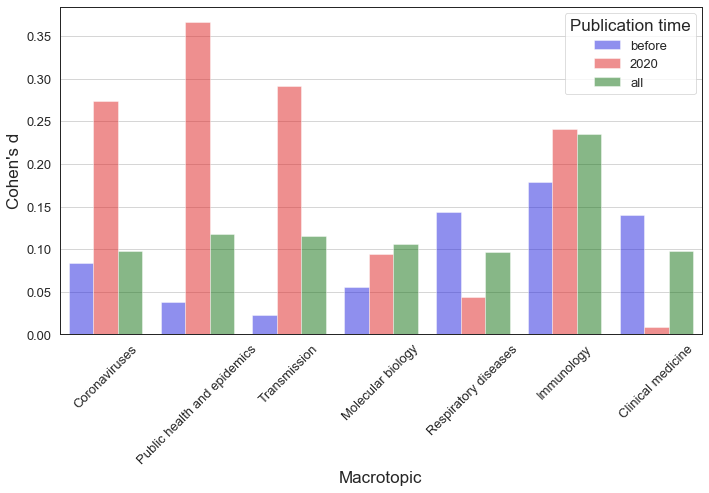

In [138]:
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="value", x="macrotopic", hue="period", hue_order=["before","2020","all"], data=df_melted_tests[df_melted_tests.variable.isin(["cohensd"])], palette=["blue","red","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Macrotopic",fontsize=17)
b.set_ylabel("Cohen's d",fontsize=17)
#b.set_title("Clustering")
b.tick_params(labelsize=13)
b.set_xticklabels(b.get_xticklabels(), rotation=45)

"""for n,p in enumerate(ax.patches):
    _x = p.get_x() + p.get_width() - 0.16
    _y = p.get_y() + p.get_height() + 0.003
    print(significances[n])
    value = significances[n]
    ax.text(_x, _y, str(value), ha="left")
""" 
#plt.xlim((0,0.4))
plt.legend(title="Publication time", fontsize=13, title_fontsize=17)
plt.tight_layout()
plt.savefig("figures/nb3_cohens_d.pdf")

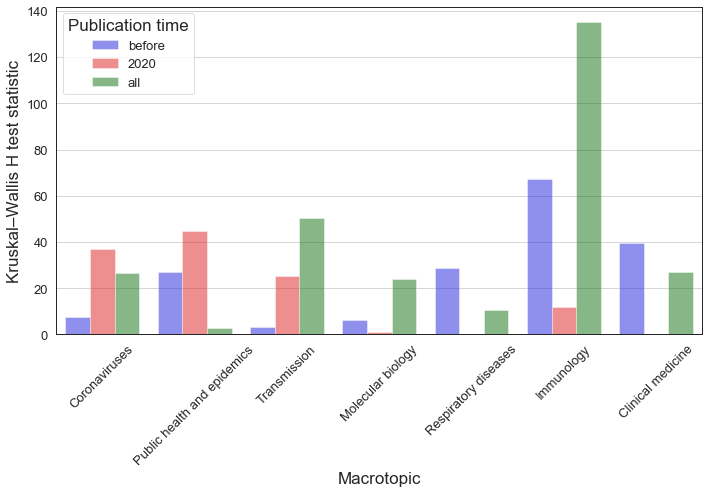

In [137]:
plt.figure(figsize=(10,7))
ax = plt.gca()
ax.grid(True)
b = sns.barplot(y="value", x="macrotopic", hue="period", hue_order=["before","2020","all"], data=df_melted_tests[df_melted_tests.variable.isin(["kwh_stat"])], palette=["blue","red","green"], alpha=0.5)
#b.axes.set_title("Title",fontsize=50)
#b.set_title("In Wikipedia",fontsize=15)
b.set_xlabel("Macrotopic",fontsize=17)
b.set_ylabel("Kruskal–Wallis H test statistic",fontsize=17)
#b.set_title("Clustering")
b.tick_params(labelsize=13)
b.set_xticklabels(b.get_xticklabels(), rotation=45)

"""
for p in ax.patches:
    _x = p.get_x() + p.get_width() - 0.16
    _y = p.get_y() + p.get_height() + 1
    value = int(p.get_width())
    ax.text(_x, _y, value, ha="left")
"""               
#plt.xlim((0,0.4))
plt.legend(title="Publication time", fontsize=13, title_fontsize=17)
plt.tight_layout()
#plt.savefig("figures/nb3_topic_model_hue_before_2020.pdf")

### Find a good value for the number of clusters (k-means)

#### Elbow method

In [42]:
# use PCA to reduce embedding size first (makes computations faster)
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=seed)
X_reduced= pca.fit_transform(X)
X_reduced.shape

(61324, 333)

In [45]:
# calculate distortions
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

distortions = []
values = range(10, 50)
for k in values:
    k_means = KMeans(n_clusters=k, random_state=seed).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'cosine'), axis=1)) / X.shape[0])

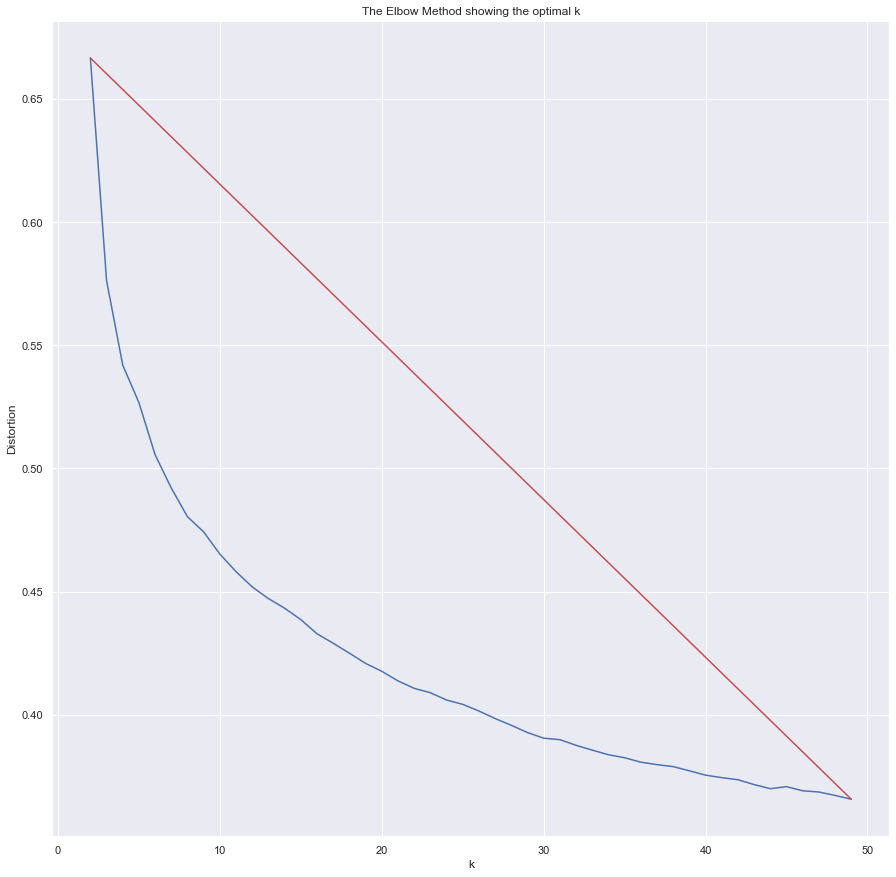

In [46]:
X_line = [values[0], values[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.plot(values, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.show()

#### Silhouette method

For n_clusters = 10 The average silhouette_score is : 0.055897716897725165
For n_clusters = 15 The average silhouette_score is : 0.04894153670518214
For n_clusters = 20 The average silhouette_score is : 0.04936273055262579
For n_clusters = 25 The average silhouette_score is : 0.047662626535926025
For n_clusters = 30 The average silhouette_score is : 0.04502606848610148
For n_clusters = 35 The average silhouette_score is : 0.045655548179418234
For n_clusters = 40 The average silhouette_score is : 0.045706688074604505
For n_clusters = 45 The average silhouette_score is : 0.04357707523742458
For n_clusters = 50 The average silhouette_score is : 0.04174141411594277


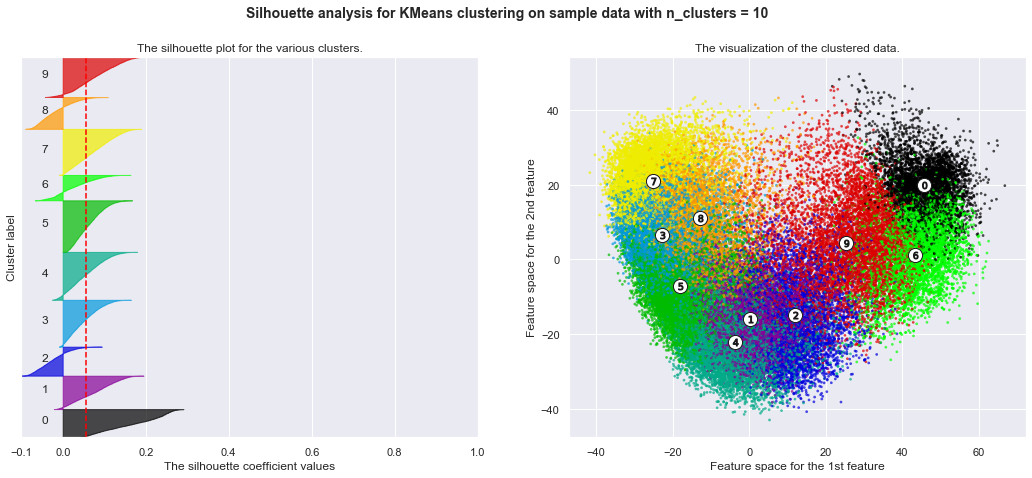

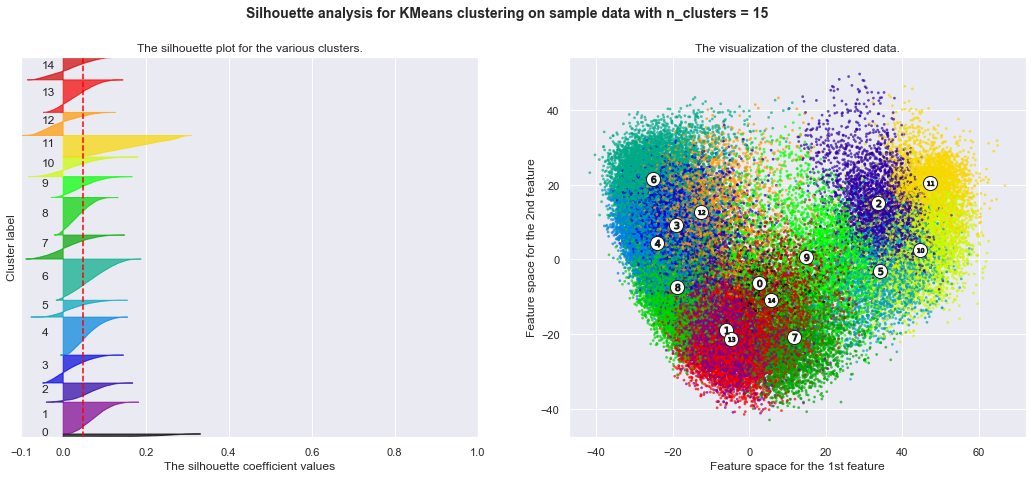

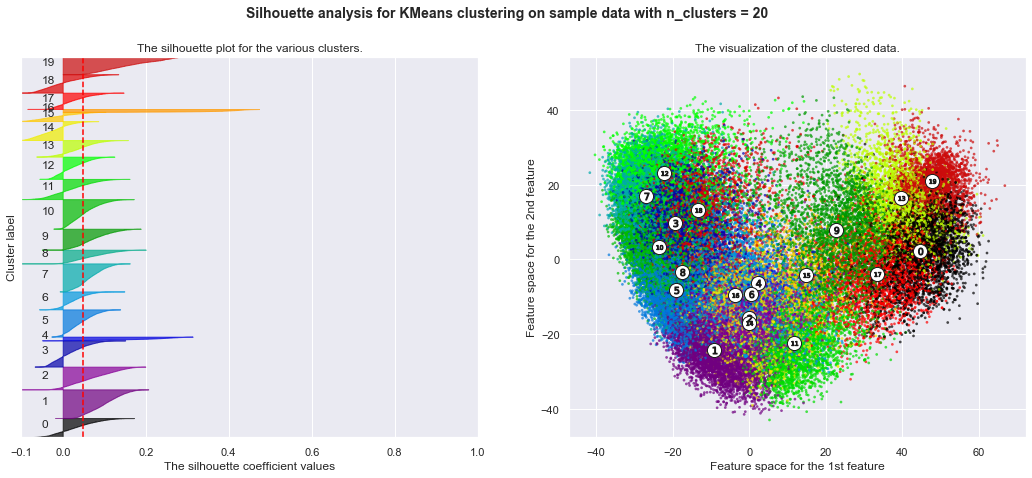

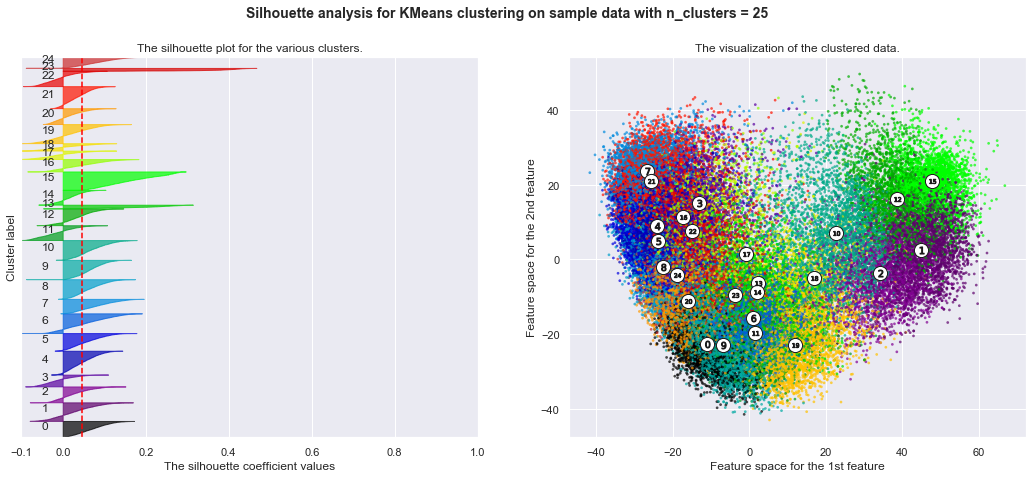

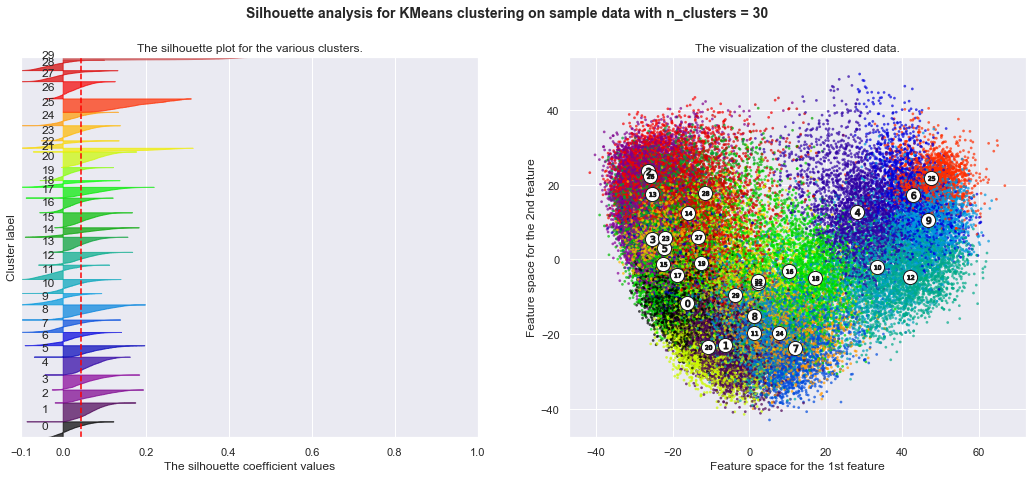

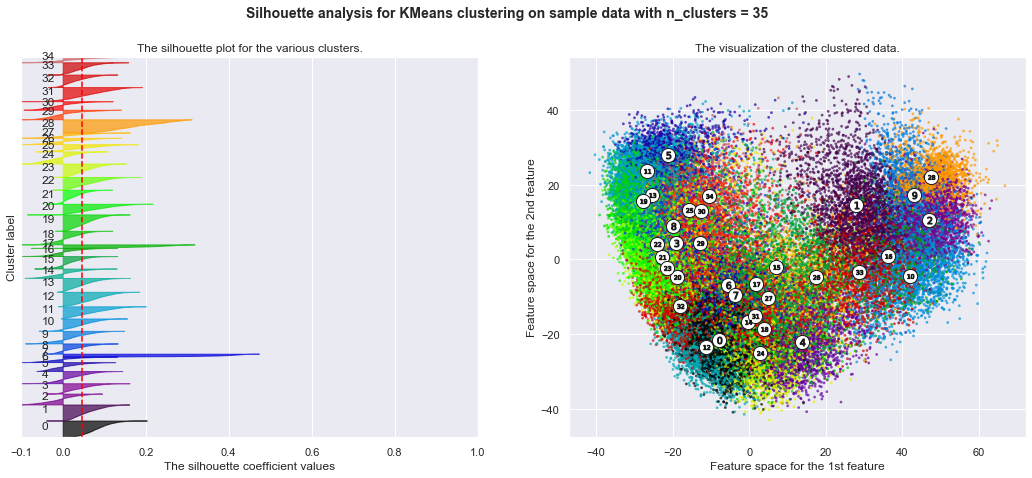

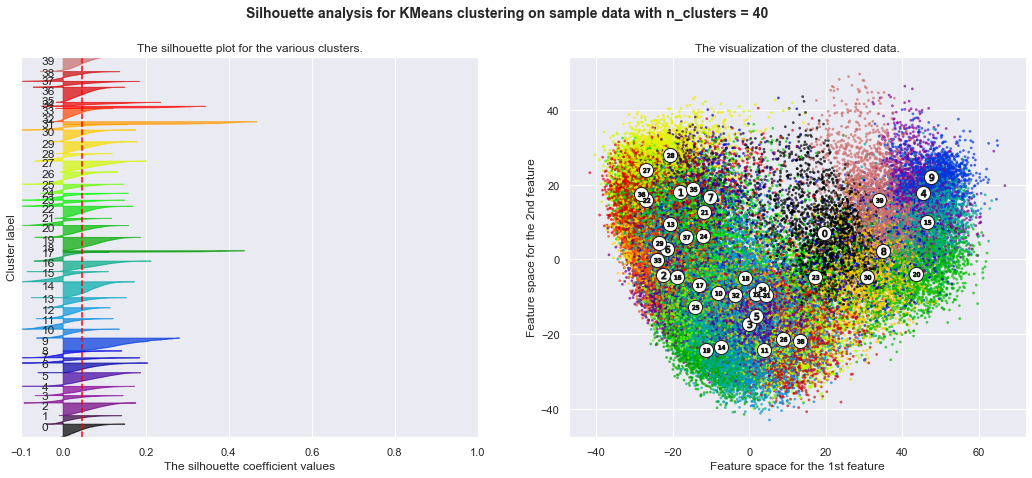

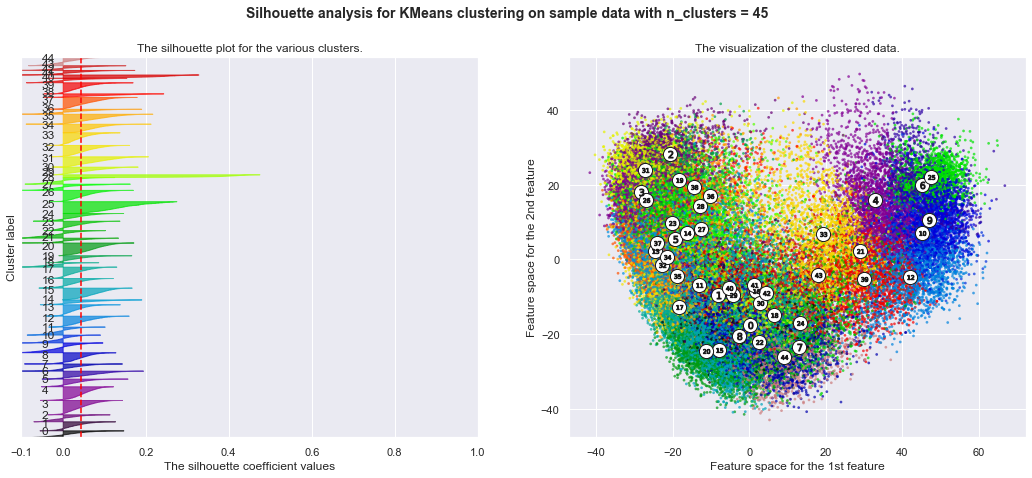

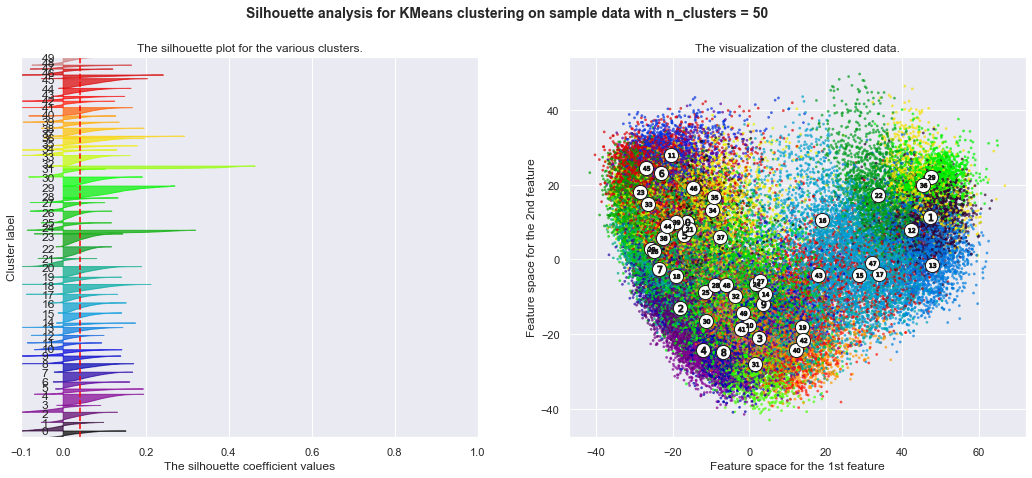

In [99]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

# FROM: https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close together.

values = range(10, 51, 5)

for k in values:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (k + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=k, random_state=seed)
    cluster_labels = clusterer.fit_predict(X_reduced)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X_reduced, cluster_labels)
    print("For n_clusters =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X_reduced, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()